In [138]:
import numpy as np
from tensorflow import keras
import pandas as pd
import os
import cv2
from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19,VGG16,inception_v3,resnet50,ResNet50,ResNet50V2,xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,classification_report,dcg_score, ndcg_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
import warnings

LeakyReLU = LeakyReLU(alpha=0.1)
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [113]:
#@title access to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read_Image_Dataset

In [114]:
# load data
batch_size=512
img_height = 100
img_width = 100
IMAGE_SIZE = [img_height, img_width]
print(img_height,img_width)

train_ds = tf.keras.utils.image_dataset_from_directory(
  'drive/MyDrive/skin cancer/melanoma_cancer_dataset', labels='inferred',
  class_names=None, color_mode='rgb',   image_size=(img_height, img_width),
  shuffle=True, batch_size=batch_size, seed=1, validation_split=0.2, subset="training",
  interpolation='bilinear', follow_links=False,crop_to_aspect_ratio=False
)
val_ds = tf.keras.utils.image_dataset_from_directory(
'drive/MyDrive/skin cancer/melanoma_cancer_dataset', labels='inferred',
  class_names=None, color_mode='rgb',   image_size=(img_height, img_width),
  shuffle=True,batch_size=batch_size, seed=1, validation_split=0.2, subset="validation",
  interpolation='bilinear', follow_links=False,crop_to_aspect_ratio=False
)

100 100
Found 10644 files belonging to 2 classes.
Using 8516 files for training.
Found 10644 files belonging to 2 classes.
Using 2128 files for validation.


#Preprocessing

In [115]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

X_train = np.concatenate([x for x, y in train_ds], axis=0)
X_test = np.concatenate([x for x, y in val_ds], axis=0) 
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_test = np.concatenate([y for x, y in val_ds], axis=0) 

#Pre-trained_Models_Function

In [136]:
def pretrained_model(pretrained_model_name,IMAGE_SIZE,input_tensor):
  pre_trained_model= Sequential()
  if pretrained_model_name=='VGG16':
    pre_trained_model = VGG16(input_tensor=Input(shape=(img_height, img_width, 3)),weights='imagenet',include_top= False) 
  if pretrained_model_name=='VGG19':
    pre_trained_model = VGG19(input_tensor=Input(shape=(img_height, img_width, 3)),weights='imagenet',include_top= False) 
  if pretrained_model_name=='inception_v3':
    pre_trained_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
  if pretrained_model_name=='resnet50':
    pre_trained_model = ResNet50(input_tensor=Input(shape=(img_height, img_width, 3)),weights='imagenet',include_top= False) 
  if pretrained_model_name=='resnet50v2':
    pre_trained_model = ResNet50V2(input_tensor=Input(shape=(img_height, img_width, 3)),weights='imagenet',include_top= False) 
  if pretrained_model_name=='xception':
    pre_trained_model = tensorflow.keras.applications.Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)

  
    
  return pre_trained_model

#Model_Function

In [117]:
def model_selection(pre_trained_model):
  for layer in pre_trained_model.layers:
    layer.trainable=False
  model= Sequential()
  model.add(pre_trained_model)
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  return model


#Compile_Model_Function

In [118]:
def model_compile(model,learning_rate):
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
      )

#fit_model_Function

In [119]:

def model_fit(model,pretrained_model_name,train_ds,val_ds,epochs,batch_size):
  print(f'---------------------------------Result of {pretrained_model_name}---------------------------------')
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=batch_size,
      shuffle=True
      )
  
  histories[pretrained_model_name]=history
  return(histories)


#Evaluate_model_Function

In [120]:
def model_evaluate(history,pretrained_model_name,epochs,batch_size,X_train,y_train,X_test,y_test,model):
  print(f'---------------------------------Result of {pretrained_model_name}---------------------------------')
  class_names=['benign', 'malignant']
  plt.figure(figsize=(12 , 6))
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  model=model
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)
  
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  model.evaluate(X_test,y_test,batch_size=batch_size)

  from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score
  y_pred=model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1)
  accuracy_score(y_pred,y_test)
  #roc_curve(y_pred,y_test)
  #confusion_matrix(y_pred,y_test)
  print(classification_report(y_pred,y_test))
  confusion_matrix(y_pred,y_test)

  import seaborn as sn

  train_label = y_train
  test_label = y_test
  predictions = np.array([])
  for x, y in val_ds:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  cm=tf.math.confusion_matrix(labels=test_label, predictions=predictions).numpy()
  #normalization
  cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(cm_norm,
                       index = class_names, 
                       columns = class_names)
  figure = plt.figure(figsize=(10, 8))
  sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  y_test=[y_test]
  y_pred=[y_pred]
  print('dcg_score=',dcg_score(y_test, y_pred))
  print('ndcg_score=',ndcg_score(y_test, y_pred))


#Hyperparameters

In [121]:
batch_size=512
learning_rate=0.0001
epochs=50
IMAGE_SIZE = [img_height, img_width]
input_tensor = Input(shape=(img_height, img_width, 3))
histories={}

#VGG16

---------------------------------Result of VGG16---------------------------------
Epoch 1/50
17/17 [==============================] - 14s 798ms/step - loss: 1.2966 - accuracy: 0.7776 - val_loss: 0.6166 - val_accuracy: 0.8797
Epoch 2/50
17/17 [==============================] - 13s 786ms/step - loss: 0.4308 - accuracy: 0.9007 - val_loss: 0.4412 - val_accuracy: 0.8759
Epoch 3/50
17/17 [==============================] - 13s 769ms/step - loss: 0.2401 - accuracy: 0.9184 - val_loss: 0.3897 - val_accuracy: 0.8849
Epoch 4/50
17/17 [==============================] - 12s 741ms/step - loss: 0.1555 - accuracy: 0.9463 - val_loss: 0.3765 - val_accuracy: 0.8844
Epoch 5/50
17/17 [==============================] - 12s 735ms/step - loss: 0.1046 - accuracy: 0.9649 - val_loss: 0.3654 - val_accuracy: 0.8957
Epoch 6/50
17/17 [==============================] - 12s 737ms/step - loss: 0.0768 - accuracy: 0.9769 - val_loss: 0.3643 - val_accuracy: 0.8990
Epoch 7/50
17/17 [==============================] - 13s 748m

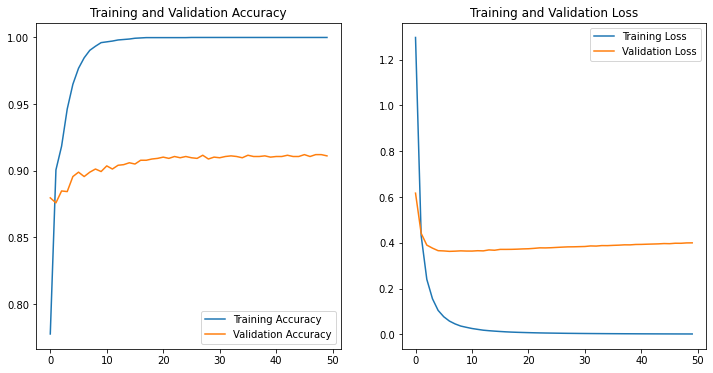

5/5 [==============================] - 3s 485ms/step - loss: 0.3995 - accuracy: 0.9112
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1103
           1       0.91      0.91      0.91      1025

    accuracy                           0.91      2128
   macro avg       0.91      0.91      0.91      2128
weighted avg       0.91      0.91      0.91      2128



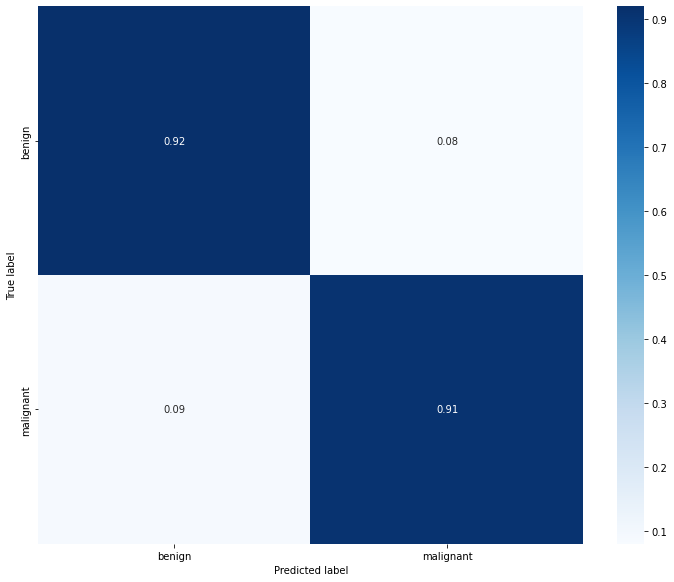

dcg_score= 123.7032469191583
ndcg_score= 0.9794824547615795


In [122]:
pretrained_model_name='VGG16'
pretrained_model=pretrained_model(pretrained_model_name,IMAGE_SIZE,input_tensor)
model=model_selection(pretrained_model)
model_compile(model,learning_rate)
histories=model_fit(model,pretrained_model_name,train_ds,val_ds,epochs,batch_size)
model_evaluate(histories[pretrained_model_name],pretrained_model_name,epochs,batch_size,X_train,y_train,X_test,y_test,model)

#VGG19

80150528/80134624 [==============================] - 6s 0us/step
---------------------------------Result of VGG19---------------------------------
Epoch 1/50
17/17 [==============================] - 17s 947ms/step - loss: 0.9068 - accuracy: 0.8232 - val_loss: 0.5369 - val_accuracy: 0.8905
Epoch 2/50
17/17 [==============================] - 16s 942ms/step - loss: 0.3111 - accuracy: 0.9062 - val_loss: 0.3642 - val_accuracy: 0.8863
Epoch 3/50
17/17 [==============================] - 15s 893ms/step - loss: 0.1821 - accuracy: 0.9333 - val_loss: 0.3540 - val_accuracy: 0.8929
Epoch 4/50
17/17 [==============================] - 15s 872ms/step - loss: 0.1140 - accuracy: 0.9600 - val_loss: 0.3411 - val_accuracy: 0.8976
Epoch 5/50
17/17 [==============================] - 15s 866ms/step - loss: 0.0812 - accuracy: 0.9745 - val_loss: 0.3443 - val_accuracy: 0.9023
Epoch 6/50
17/17 [==============================] - 15s 912ms/step - loss: 0.0581 - accuracy: 0.9838 - val_loss: 0.3477 - val_accuracy: 0.

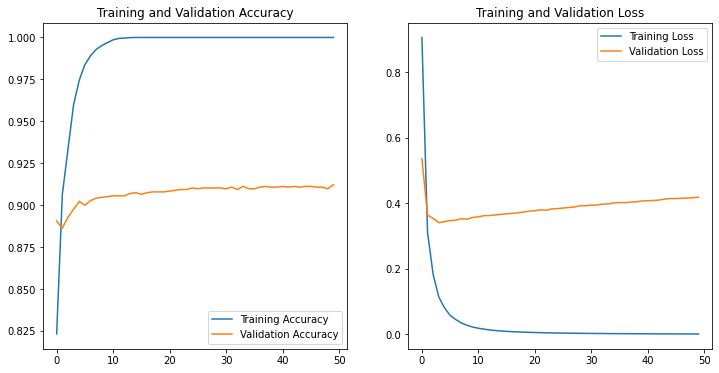

5/5 [==============================] - 3s 576ms/step - loss: 0.4191 - accuracy: 0.9121
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1123
           1       0.90      0.92      0.91      1005

    accuracy                           0.91      2128
   macro avg       0.91      0.91      0.91      2128
weighted avg       0.91      0.91      0.91      2128



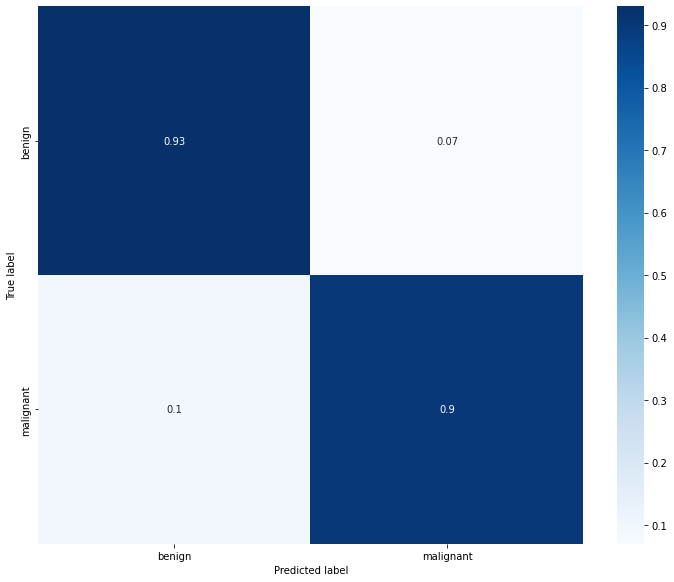

dcg_score= 123.87427174311496
ndcg_score= 0.9808366295190433


In [125]:
pretrained_model_name='VGG19'
pretrained_model=pretrained_model(pretrained_model_name,IMAGE_SIZE,input_tensor)
model=model_selection(pretrained_model)
model_compile(model,learning_rate)
histories=model_fit(model,pretrained_model_name,train_ds,val_ds,epochs,batch_size)
model.summary()
model_evaluate(histories[pretrained_model_name],pretrained_model_name,epochs,batch_size,X_train,y_train,X_test,y_test,model)

#Inception_V3

---------------------------------Result of inception_v3---------------------------------
Epoch 1/50
17/17 [==============================] - 9s 294ms/step - loss: 7.4336 - accuracy: 0.6881 - val_loss: 2.8041 - val_accuracy: 0.7368
Epoch 2/50
17/17 [==============================] - 3s 204ms/step - loss: 2.0013 - accuracy: 0.7477 - val_loss: 1.6417 - val_accuracy: 0.7472
Epoch 3/50
17/17 [==============================] - 3s 204ms/step - loss: 1.2951 - accuracy: 0.7718 - val_loss: 1.1007 - val_accuracy: 0.7796
Epoch 4/50
17/17 [==============================] - 3s 206ms/step - loss: 1.0103 - accuracy: 0.7831 - val_loss: 1.1369 - val_accuracy: 0.7570
Epoch 5/50
17/17 [==============================] - 4s 214ms/step - loss: 0.9416 - accuracy: 0.7886 - val_loss: 0.8857 - val_accuracy: 0.7899
Epoch 6/50
17/17 [==============================] - 4s 212ms/step - loss: 0.9878 - accuracy: 0.7776 - val_loss: 1.0076 - val_accuracy: 0.7876
Epoch 7/50
17/17 [==============================] - 4s 213m

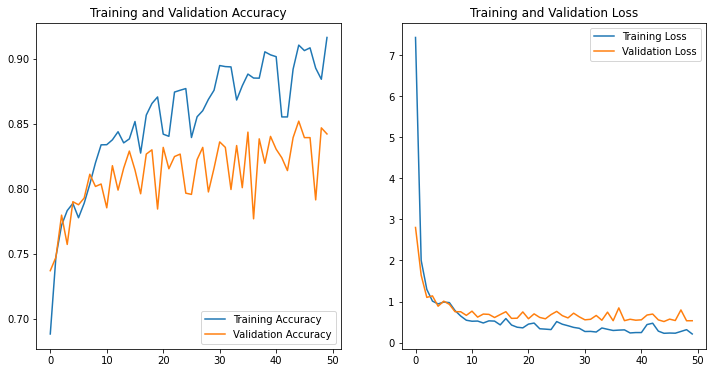

5/5 [==============================] - 1s 132ms/step - loss: 0.5319 - accuracy: 0.8421
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1050
           1       0.86      0.82      0.84      1078

    accuracy                           0.84      2128
   macro avg       0.84      0.84      0.84      2128
weighted avg       0.84      0.84      0.84      2128



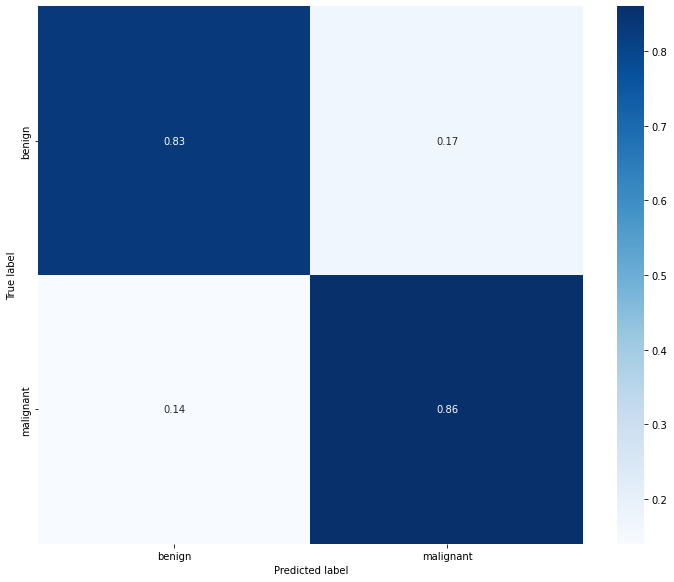

dcg_score= 121.34704885180014
ndcg_score= 0.9608260756899074


In [128]:
pretrained_model_name='inception_v3'
pretrained_model=pretrained_model(pretrained_model_name,IMAGE_SIZE,input_tensor)
model=model_selection(pretrained_model)
model_compile(model,learning_rate)
histories=model_fit(model,pretrained_model_name,train_ds,val_ds,epochs,batch_size)
model.summary()
model_evaluate(histories[pretrained_model_name],pretrained_model_name,epochs,batch_size,X_train,y_train,X_test,y_test,model)

#ResNet50

---------------------------------Result of resnet50---------------------------------
Epoch 1/50
17/17 [==============================] - 13s 591ms/step - loss: 0.3343 - accuracy: 0.8639 - val_loss: 0.2183 - val_accuracy: 0.9145
Epoch 2/50
17/17 [==============================] - 9s 541ms/step - loss: 0.1520 - accuracy: 0.9428 - val_loss: 0.2105 - val_accuracy: 0.9248
Epoch 3/50
17/17 [==============================] - 9s 564ms/step - loss: 0.1021 - accuracy: 0.9630 - val_loss: 0.2106 - val_accuracy: 0.9229
Epoch 4/50
17/17 [==============================] - 9s 564ms/step - loss: 0.0700 - accuracy: 0.9795 - val_loss: 0.2027 - val_accuracy: 0.9286
Epoch 5/50
17/17 [==============================] - 9s 546ms/step - loss: 0.0477 - accuracy: 0.9895 - val_loss: 0.1990 - val_accuracy: 0.9281
Epoch 6/50
17/17 [==============================] - 9s 544ms/step - loss: 0.0332 - accuracy: 0.9940 - val_loss: 0.2074 - val_accuracy: 0.9276
Epoch 7/50
17/17 [==============================] - 9s 527ms/s

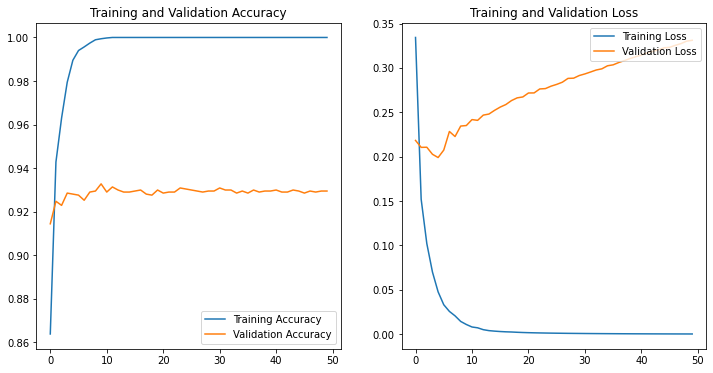

5/5 [==============================] - 2s 336ms/step - loss: 0.3311 - accuracy: 0.9295
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1112
           1       0.92      0.93      0.93      1016

    accuracy                           0.93      2128
   macro avg       0.93      0.93      0.93      2128
weighted avg       0.93      0.93      0.93      2128



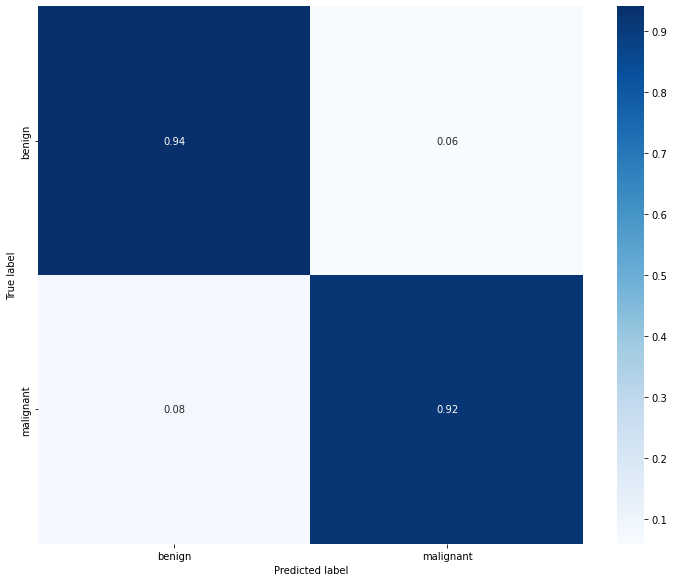

dcg_score= 124.3170049387335
ndcg_score= 0.9843421914832517


In [130]:
pretrained_model_name='resnet50'
pretrained_model=pretrained_model(pretrained_model_name,IMAGE_SIZE,input_tensor)
model=model_selection(pretrained_model)
model_compile(model,learning_rate)
histories=model_fit(model,pretrained_model_name,train_ds,val_ds,epochs,batch_size)
model.summary()
model_evaluate(histories[pretrained_model_name],pretrained_model_name,epochs,batch_size,X_train,y_train,X_test,y_test,model)

#ResNet50v2

---------------------------------Result of resnet50---------------------------------
Epoch 1/50
17/17 [==============================] - 12s 578ms/step - loss: 0.7705 - accuracy: 0.7513 - val_loss: 0.2609 - val_accuracy: 0.8891
Epoch 2/50
17/17 [==============================] - 9s 534ms/step - loss: 0.2321 - accuracy: 0.9032 - val_loss: 0.2370 - val_accuracy: 0.9018
Epoch 3/50
17/17 [==============================] - 9s 540ms/step - loss: 0.1750 - accuracy: 0.9298 - val_loss: 0.2060 - val_accuracy: 0.9159
Epoch 4/50
17/17 [==============================] - 9s 543ms/step - loss: 0.1379 - accuracy: 0.9479 - val_loss: 0.1957 - val_accuracy: 0.9234
Epoch 5/50
17/17 [==============================] - 9s 541ms/step - loss: 0.1148 - accuracy: 0.9601 - val_loss: 0.1904 - val_accuracy: 0.9253
Epoch 6/50
17/17 [==============================] - 9s 537ms/step - loss: 0.0967 - accuracy: 0.9699 - val_loss: 0.1937 - val_accuracy: 0.9229
Epoch 7/50
17/17 [==============================] - 9s 533ms/s

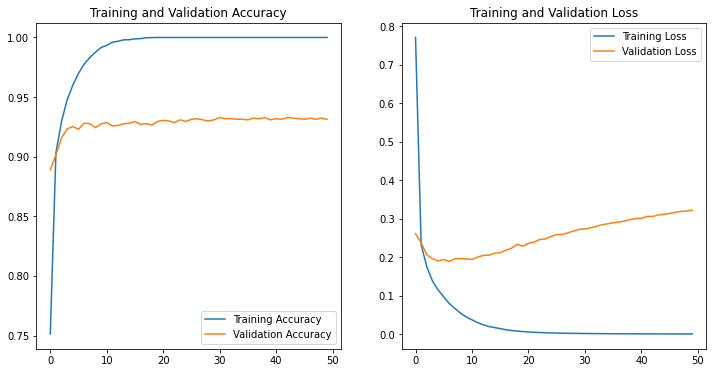

5/5 [==============================] - 2s 336ms/step - loss: 0.3219 - accuracy: 0.9314
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1106
           1       0.92      0.93      0.93      1022

    accuracy                           0.93      2128
   macro avg       0.93      0.93      0.93      2128
weighted avg       0.93      0.93      0.93      2128



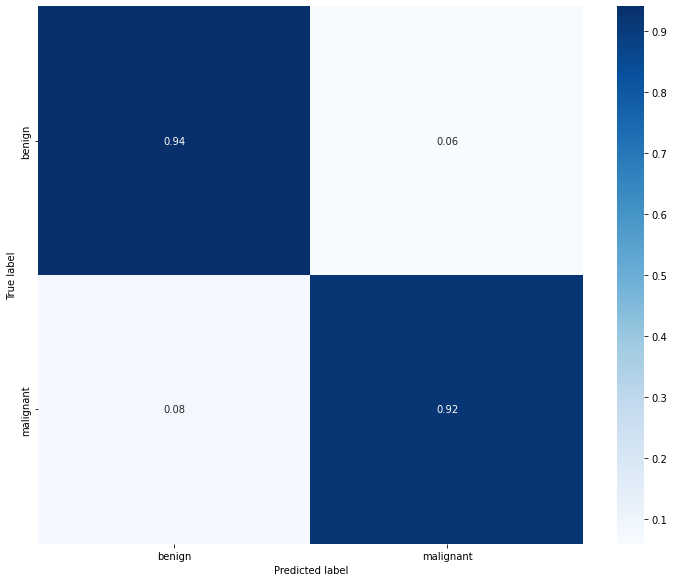

dcg_score= 124.32868583984052
ndcg_score= 0.9844346808719708


In [132]:
pretrained_model_name='resnet50'
pretrained_model=pretrained_model(pretrained_model_name,IMAGE_SIZE,input_tensor)
model=model_selection(pretrained_model)
model_compile(model,learning_rate)
histories=model_fit(model,pretrained_model_name,train_ds,val_ds,epochs,batch_size)
model.summary()
model_evaluate(histories[pretrained_model_name],pretrained_model_name,epochs,batch_size,X_train,y_train,X_test,y_test,model)

#Xception

83697664/83683744 [==============================] - 2s 0us/step
---------------------------------Result of xception---------------------------------
Epoch 1/50
17/17 [==============================] - 20s 814ms/step - loss: 11.3745 - accuracy: 0.6616 - val_loss: 1.6611 - val_accuracy: 0.7834
Epoch 2/50
17/17 [==============================] - 9s 554ms/step - loss: 1.0343 - accuracy: 0.7667 - val_loss: 0.4672 - val_accuracy: 0.8106
Epoch 3/50
17/17 [==============================] - 9s 544ms/step - loss: 0.4534 - accuracy: 0.8195 - val_loss: 0.3691 - val_accuracy: 0.8454
Epoch 4/50
17/17 [==============================] - 9s 519ms/step - loss: 0.3369 - accuracy: 0.8522 - val_loss: 0.3195 - val_accuracy: 0.8590
Epoch 5/50
17/17 [==============================] - 9s 508ms/step - loss: 0.3187 - accuracy: 0.8614 - val_loss: 0.3252 - val_accuracy: 0.8651
Epoch 6/50
17/17 [==============================] - 8s 502ms/step - loss: 0.2866 - accuracy: 0.8774 - val_loss: 0.3232 - val_accuracy: 0.8

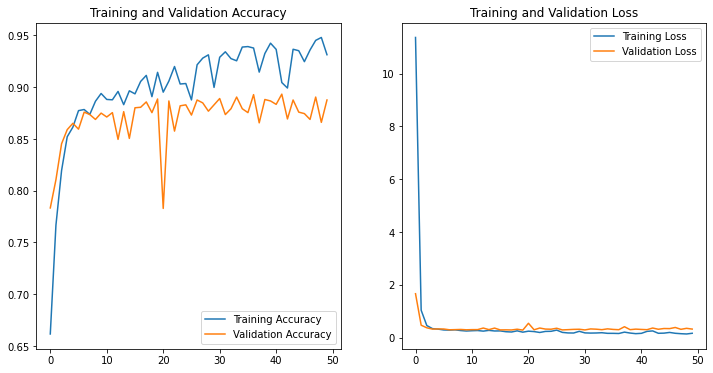

5/5 [==============================] - 2s 337ms/step - loss: 0.3199 - accuracy: 0.8877
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1149
           1       0.86      0.91      0.88       979

    accuracy                           0.89      2128
   macro avg       0.89      0.89      0.89      2128
weighted avg       0.89      0.89      0.89      2128



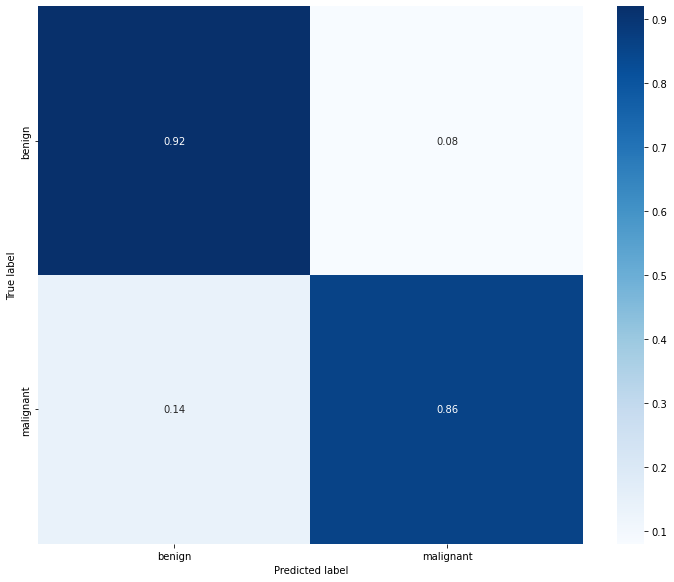

dcg_score= 123.31628964759044
ndcg_score= 0.9764185266296782


In [139]:
pretrained_model_name='xception'
pretrained_model=pretrained_model(pretrained_model_name,IMAGE_SIZE,input_tensor)
model=model_selection(pretrained_model)
model_compile(model,learning_rate)
histories=model_fit(model,pretrained_model_name,train_ds,val_ds,epochs,batch_size)
model.summary()
model_evaluate(histories[pretrained_model_name],pretrained_model_name,epochs,batch_size,X_train,y_train,X_test,y_test,model)

Text(0, 0.5, 'ndcg')

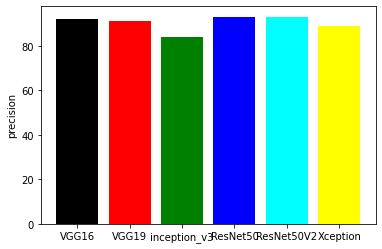

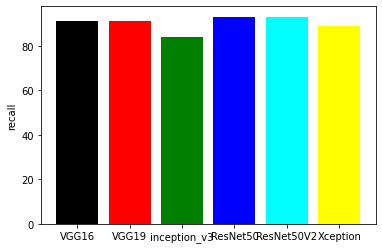

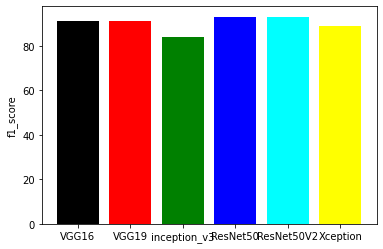

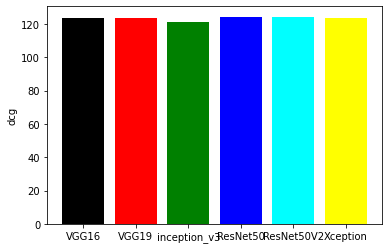

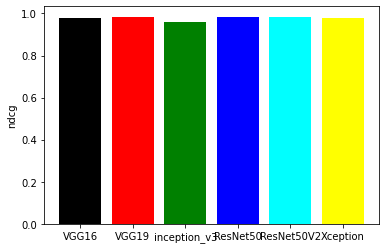

In [162]:
precision={'VGG16':92,'VGG19':91 ,'inception_v3':84 ,'ResNet50':93 ,'ResNet50V2':93 ,'Xception':89}
recall={'VGG16':91,'VGG19':91 ,'inception_v3':84 ,'ResNet50':93 ,'ResNet50V2':93 ,'Xception':89}
f1_score={'VGG16':91,'VGG19':91 ,'inception_v3':84 ,'ResNet50':93 ,'ResNet50V2':93 ,'Xception':89}
dcg={'VGG16':123.70,'VGG19':123.784 ,'inception_v3':121.347,'ResNet50':124.317 ,'ResNet50V2':124.328 ,'Xception':123.316}
ndcg={'VGG16':0.979,'VGG19':0.9808 ,'inception_v3':0.9608,'ResNet50':0.984 ,'ResNet50V2':0.984 ,'Xception':0.976}

precision_keys = precision.keys()
precision_values = precision.values()
recall_values = recall.values()
f1_score_values = f1_score.values()
dcg_values = dcg.values()
ndcg_values = ndcg.values()

figure, axis = plt.subplots(1, 1)
plt.bar(precision_keys, precision_values, color=['black', 'red', 'green', 'blue', 'cyan','yellow'])
plt.ylabel('precision')
figure, axis = plt.subplots(1, 1)
plt.bar(precision_keys, recall_values, color=['black', 'red', 'green', 'blue', 'cyan','yellow'])
plt.ylabel('recall')
figure, axis = plt.subplots(1, 1)
plt.bar(precision_keys, f1_score_values, color=['black', 'red', 'green', 'blue', 'cyan','yellow'])
plt.ylabel('f1_score')
figure, axis = plt.subplots(1, 1)
plt.bar(precision_keys, dcg_values, color=['black', 'red', 'green', 'blue', 'cyan','yellow'])
plt.ylabel('dcg')
figure, axis = plt.subplots(1, 1)
plt.bar(precision_keys, ndcg_values, color=['black', 'red', 'green', 'blue', 'cyan','yellow'])
plt.ylabel('ndcg')
